In [1]:
import sys
sys.path.append("../projects/ConvSharing/")
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import conv_sharing
from conv_sharing.model import helper

In [2]:
def draw_mat(ax, mat, cmap=None):
    if cmap is None:
        cmap = 'tab20c'
    cax = ax.matshow(mat, interpolation='nearest', cmap=cmap)
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '%d'%z, ha='center', va='center', size=20)
    plt.axis('off')
    return ax

# Illustration of Convolution as a Linear System
Consider a convolution with the kernel $[1,2]$, we can write it as a linear system with a Linear operator $G$.

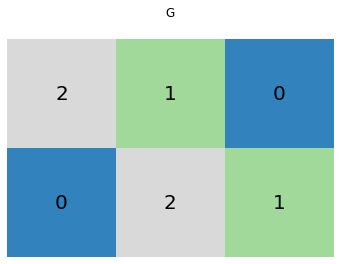

In [3]:
input_dim = 3
ksize = 2
G = helper.generate_conv_teoplitz(input_dim, ksize)
fig = plt.figure()
ax = fig.add_subplot(111)
draw_mat(ax, G)
ax.title.set_text('G')

Observe that the values in $G$ are shared. We can encode this sharing scheme by using an assignment matrix $\mathbf{A}$, where $\mathbf{A}\psi=\text{Flatten}(G)$, as illustrated below.

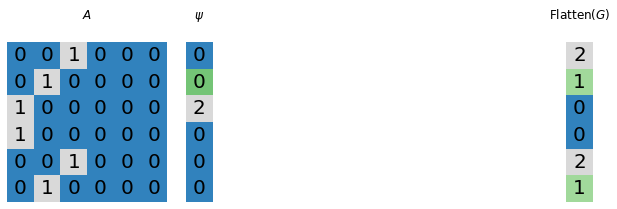

In [4]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(311)
G_flatten = np.reshape(G,(1,-1)).T
draw_mat(ax, G_flatten)
ax.title.set_text('Flatten($G$)')
ax = fig.add_subplot(331)
A = helper.generate_conv_A(input_dim, ksize)
ax = draw_mat(ax, A)
ax.title.set_text('$A$')
A_plus = scipy.linalg.pinv(A)
psi = A_plus.dot(G_flatten)
ax = fig.add_subplot(321)
ax = draw_mat(ax, psi)
ax.title.set_text('$\psi$')

# Recovering the sharing scheme from data.
We will next demo how to recover this $\mathbf{A}$ from data.

In [5]:
import torch
from conv_sharing.data.conv1d_dataset import Conv1DDataset
# Create some data
kernel = (1.+1*torch.arange(ksize).unsqueeze(0).unsqueeze(0).float())
print(kernel)
train_data = Conv1DDataset(num_samples=50, dim=input_dim, ksize=ksize,split='TRAIN',weight=kernel)
val_data = Conv1DDataset(num_samples=100, dim=input_dim, ksize=ksize,split='VAL',weight=kernel)

tensor([[[1., 2.]]])


In [6]:
# Create our model
from conv_sharing.model.closed_linear_model import ClosedLinearModel
model = ClosedLinearModel(dim=input_dim, ksize=ksize)
model.fit_model_parameters(train_data)  # Closed form lower-level optimization
A_optimizer = torch.optim.Adam(model.hyper_parameters(), 0.1)
# Perform gradient descent on A to optimize upper-level.
for n_epoch in range(1000):
    y_pred = model(val_data.x)
    loss = model.total_val_loss(y_pred,val_data.y)
    model.zero_grad()
    loss.backward()
    A_optimizer.step()

In [7]:
# Prediction
A_indices = model.get_A().argmax(-1).cpu().numpy()
A_val = np.zeros((input_dim*ksize,input_dim*ksize))
A_val[np.arange(input_dim*ksize), A_indices] = 1

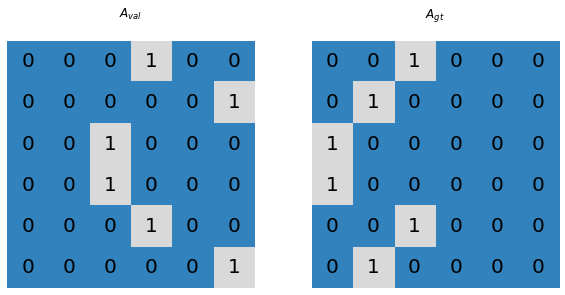

In [8]:
fig = plt.figure(figsize=(20 ,10))
ax = fig.add_subplot(221)
ax = draw_mat(ax, A_val)
ax.title.set_text('$A_{val}$')
ax = fig.add_subplot(211)
ax = draw_mat(ax, A)
ax.title.set_text('$A_{gt}$')

While $A_{val}$ and $A_{gt}$ encodes the same sharing scheme an elementwise comparison will not be accurate. This is because $A$ is not unique as $\psi$ can be permuted. To see this, try permuting the columns of $A_{val}$.
Hence, we propose to use partition distance to quantitatively evaluate the recovery performance.

In [9]:
from struct_discovery.evaluation.partition_distance import partition_distance

In [10]:
print('L2-Norm: %s' % np.sum(np.square(A_val-A)))
print('Parition distance:%s' % partition_distance(A_val, A))

L2-Norm: 12.0
Parition distance:0.0


Observe that we have successfully recovered the sharing scheme!